# **Bài toán**

Khuôn mặt là một trong những đặc điểm sinh trắc học quan trọng nhất của con người. Bằng việc phân tích dữ liệu khuôn mặt, ta có thể thu thập được rất nhiều thông tin như tuổi tác, giới tính, chủng tộc, nhân dạng, biểu cảm,... Việc phân loại xác định giới tính là sử dụng hình ảnh từ khuôn mặt của một người bất kì để phân tích dự đoán người đó thuộc 1 trong 2 giới tính sinh học nam hoặc nữ. Một mô hình dự đoán giới tính hiệu quả có thể củng cố độ chính xác của mô hình nhận diện khuôn mặt, tăng hiệu quả tương tác giữa robot AI và thế giới xung quanh, tạo ra thêm nhiều dữ liệu cho các mô hình khác hoạt động, ...

In [1]:
import numpy as np  # Data manipulation
import pandas as pd # Dataframe manipulation 
import matplotlib.pyplot as plt # Plotting the data and the results
import matplotlib.image as mpimg # For displayinwg imagees
%matplotlib inline
from tensorflow import keras
from keras import models
from keras import layers
import keras.preprocessing as kp
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from skimage.transform import resize #resize image

# **Thông tin về dữ liệu**

Dữ liệu bao gồm gần 59 nghìn bức ảnh, được chia sẵn thành 2 tập Training (23.000 mẫu/loại) và Validation/Test (5.500 mẫu/loại), được tiền xử lí qua việc xác định và cắt khuôn mặt ra khỏi background, giúp giảm được nhiễu loạn trong dự đoán từ đó:

*   Khiến cho việc tính toán bớt nặng nhọc hơn cho cơ sở hạ tầng phần cứng hạn chế.
*   Mô hình để giải quyết vấn đề yêu cầu ít sự phức tạp hơn, giảm thời gian triển khai mô hình và có nhiều thời gian hơn cho tối ưu.

*   Giữ được sự ổn định trong dự đoán, giảm sai sót với những trường hợp đặc biệt mà mô hình chưa từng thấy.



Thông tin về bộ dữ liệu: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

Code dưới đây dùng cho việc tải lên dữ liệu và chạy mô hình trên Google Colab. **MyData.zip** là file nén zip phải được tải lên Google Drive trước đó, chứa toàn bộ dữ liệu cho việc huấn luyện và thử nghiệm mô hình. Hãy chạy đoạn code dưới nếu bạn đang chạy file này trên Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/archive.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Validation/male/067031.jpg.jpg  
  inflating: /content/data/Validation/male/067038.jpg.jpg  
  inflating: /content/data/Validation/male/067040.jpg.jpg  
  inflating: /content/data/Validation/male/067046.jpg.jpg  
  inflating: /content/data/Validation/male/067048.jpg.jpg  
  inflating: /content/data/Validation/male/067054.jpg.jpg  
  inflating: /content/data/Validation/male/067064.jpg.jpg  
  inflating: /content/data/Validation/male/067068.jpg.jpg  
  inflating: /content/data/Validation/male/067069.jpg.jpg  
  inflating: /content/data/Validation/male/067086.jpg.jpg  
  inflating: /content/data/Validation/male/067091.jpg.jpg  
  inflating: /content/data/Validation/male/067099.jpg.jpg  
  inflating: /content/data/Validation/male/067101.jpg.jpg  
  inflating: /content/data/Validation/male/067102.jpg.jpg  
  inflating: /content/data/Validation/male/067112.jpg.jpg  
  inflating: /content/data/Validation/male/067117

# **Tiền xử lí dữ liệu**

In [3]:
import os

train=[len(os.listdir("data/Training/male")),len(os.listdir("data/Training/female"))]
val=[len(os.listdir("data/Validation/male")),len(os.listdir("data/Validation/female"))]
data_stat=pd.DataFrame([train,val], index=['train','val'], columns=['male','female'])
data_stat

,male,female
train,23766,23243
val,5808,5841


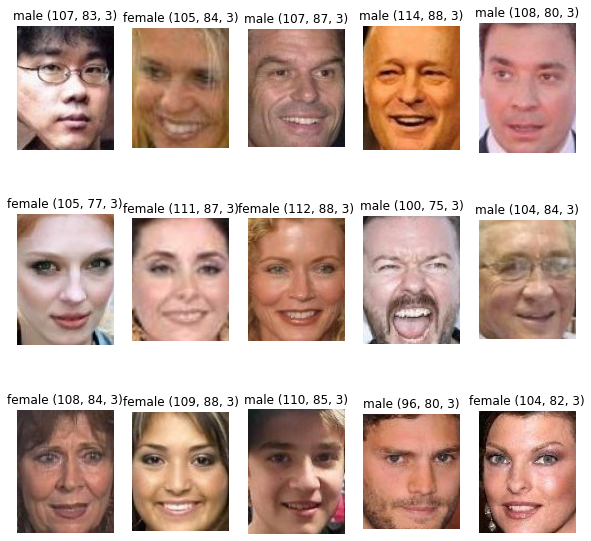

In [5]:
import random
tb_size=(3,5)

_,pic=plt.subplots(tb_size[0], tb_size[1],figsize=(10,10))
for i in range(tb_size[0]):
  for j in range(tb_size[1]):
    class_num = random.randrange(2)
    if (class_num==0):
      img_list=os.listdir('data/Validation/male')
      pic_num=random.randrange(len(img_list))
      pic_arr=keras.utils.img_to_array(keras.utils.load_img('data/Validation/male/'+ img_list[pic_num]))
      pic[i][j].imshow(pic_arr/255)
      pic[i][j].set_title('male '+ str(pic_arr.shape))
      pic[i][j].axis('off')
    else:
      img_list=os.listdir('data/Validation/female')
      pic_num=random.randrange(len(img_list))
      pic_arr=keras.utils.img_to_array(keras.utils.load_img('data/Validation/female/'+ img_list[pic_num]))
      pic[i][j].imshow(pic_arr/255)
      pic[i][j].set_title('female '+ str(pic_arr.shape))
      pic[i][j].axis('off')
    

Các tham số rotate, shear, zoom lần lượt qui định độ xoay, mức độ thu phóng, tỉ lệ cắt của hình ảnh đầu vào. Những tham số này cùng nhiều tham số không được sử dụng trong bài này sẽ làm cho đầu vào trở nên đa dạng từ đó góp phần không nhỏ trong việc dự đoán các trường hợp khó gặp khi mô hình chỉ được huấn luyện qua đầu vào chỉ gồm những bức hình không qua chỉnh sửa.

In [6]:
rotate=30
shear=0.3
zoom=0.3
batch_s=48
img_s=(150,150)

Việc truyền bộ dữ liệu đầu vào sử dụng tính năng ImageDataGenerator của Tensorflow. Đây là một class đắc lực cho CV, cung cấp cho người dùng đa dạng các phương thức, khiến việc nhập dữ liệu dạng hình ảnh vô cùng đơn giản chỉ qua vài tham số.

Ngoài ra, ImageDataGenerator còn giúp người dùng resize các hình về cùng một kích thước chỉ định và giúp chia dữ liệu ra thành từng batch nhỏ để sử dụng Batch Normalization, từ đó việc huấn luyện trở nên nhanh và ổn định hơn.

Với ImageDataGenerator, việc xử lí dữ liệu đầu vào và chuẩn hóa dữ liệu, tối ưu hiệu quả huấn luyện trở nên vô cùng đơn giản khi chỉ cần điều chỉnh vài thông số mà không cần phải code quá nhiều.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=rotate,
                                   shear_range=shear,
                                   zoom_range=zoom)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_gen=train_datagen.flow_from_directory('/content/data/Training',
                                            target_size=img_s,
                                            batch_size=batch_s,
                                            class_mode='binary')

Found 47009 images belonging to 2 classes.


In [9]:
valid_gen=test_datagen.flow_from_directory('/content/data/Validation',
                                           target_size=img_s,
                                           batch_size=batch_s,
                                           class_mode='binary')

Found 11649 images belonging to 2 classes.


Sau khi truyền, dữ liệu hình ảnh được lưu trữ lần lượt vào hai biến train_gen và valid_gen tương ứng với tập Training và Validation.

Bản chất của biến train_gen và valid_gen một loạt các tuple tương ứng với số batch, mỗi tuple bao gồm 1 mảng 4 chiều chứa các số thực của 3 kênh RGB được chuyển đổi từ hình ảnh và 1 mảng 1 chiều chứa nhãn phân loại nam hoặc nữ tương ứng. Số lượng phần tử của hai tuple này tương ứng với kích thước của 1 batch.

In [10]:
print("Chiều dài của train_gen tương ứng với số batch: ",len(train_gen))
print("Kiểu của từng phần tử trong train_gen: ", type(train_gen[0]))
print('Kích thước phần tử thứ nhất của mỗi tuple: ', train_gen[0][0].shape)
print('Kích thước phần tử thứ hai của mỗi tuple: ', train_gen[0][1].shape)

Chiều dài của train_gen tương ứng với số batch:  980
Kiểu của từng phần tử trong train_gen:  <class 'tuple'>
Kích thước phần tử thứ nhất của mỗi tuple:  (48, 150, 150, 3)
Kích thước phần tử thứ hai của mỗi tuple:  (48,)


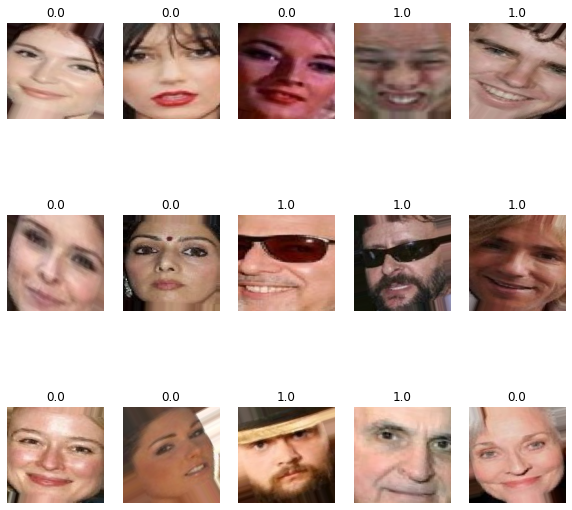

In [11]:
import random
tb_size=(3,5)

_,pic=plt.subplots(tb_size[0], tb_size[1],figsize=(10,10))
for i in range(tb_size[0]):
  for j in range(tb_size[1]):
    batch_num=random.randrange(980)
    indice = random.randrange(train_gen[batch_num][1].shape[0])
    
    pic[i][j].imshow(train_gen[batch_num][0][indice])
    pic[i][j].set_title(train_gen[batch_num][1][indice])
    pic[i][j].axis("off")

Như ta đã thấy, ImageDataGenerator đánh số phân loại 1 tương ứng với Nam và 0 tương ứng với Nữ.

# **Dựng mô hình**

In [12]:
kernel_n=(32,64,256,256,128)
kernel_s=(3,3)
reg_type=regularizers.l2(0.001)

Một số tham số quan trọng được đặt chung để tiện cho việc điều chỉnh. 

Trong bài này sử dụng mô hình với 4 Convolutional Layers xen kẽ là các MaxPooling Layers và cuối cùng là lớp Dense/Fully Connected để đưa ra dự đoán.

Sơ lược về tác dụng của các lớp:

Convolutional Layer: 
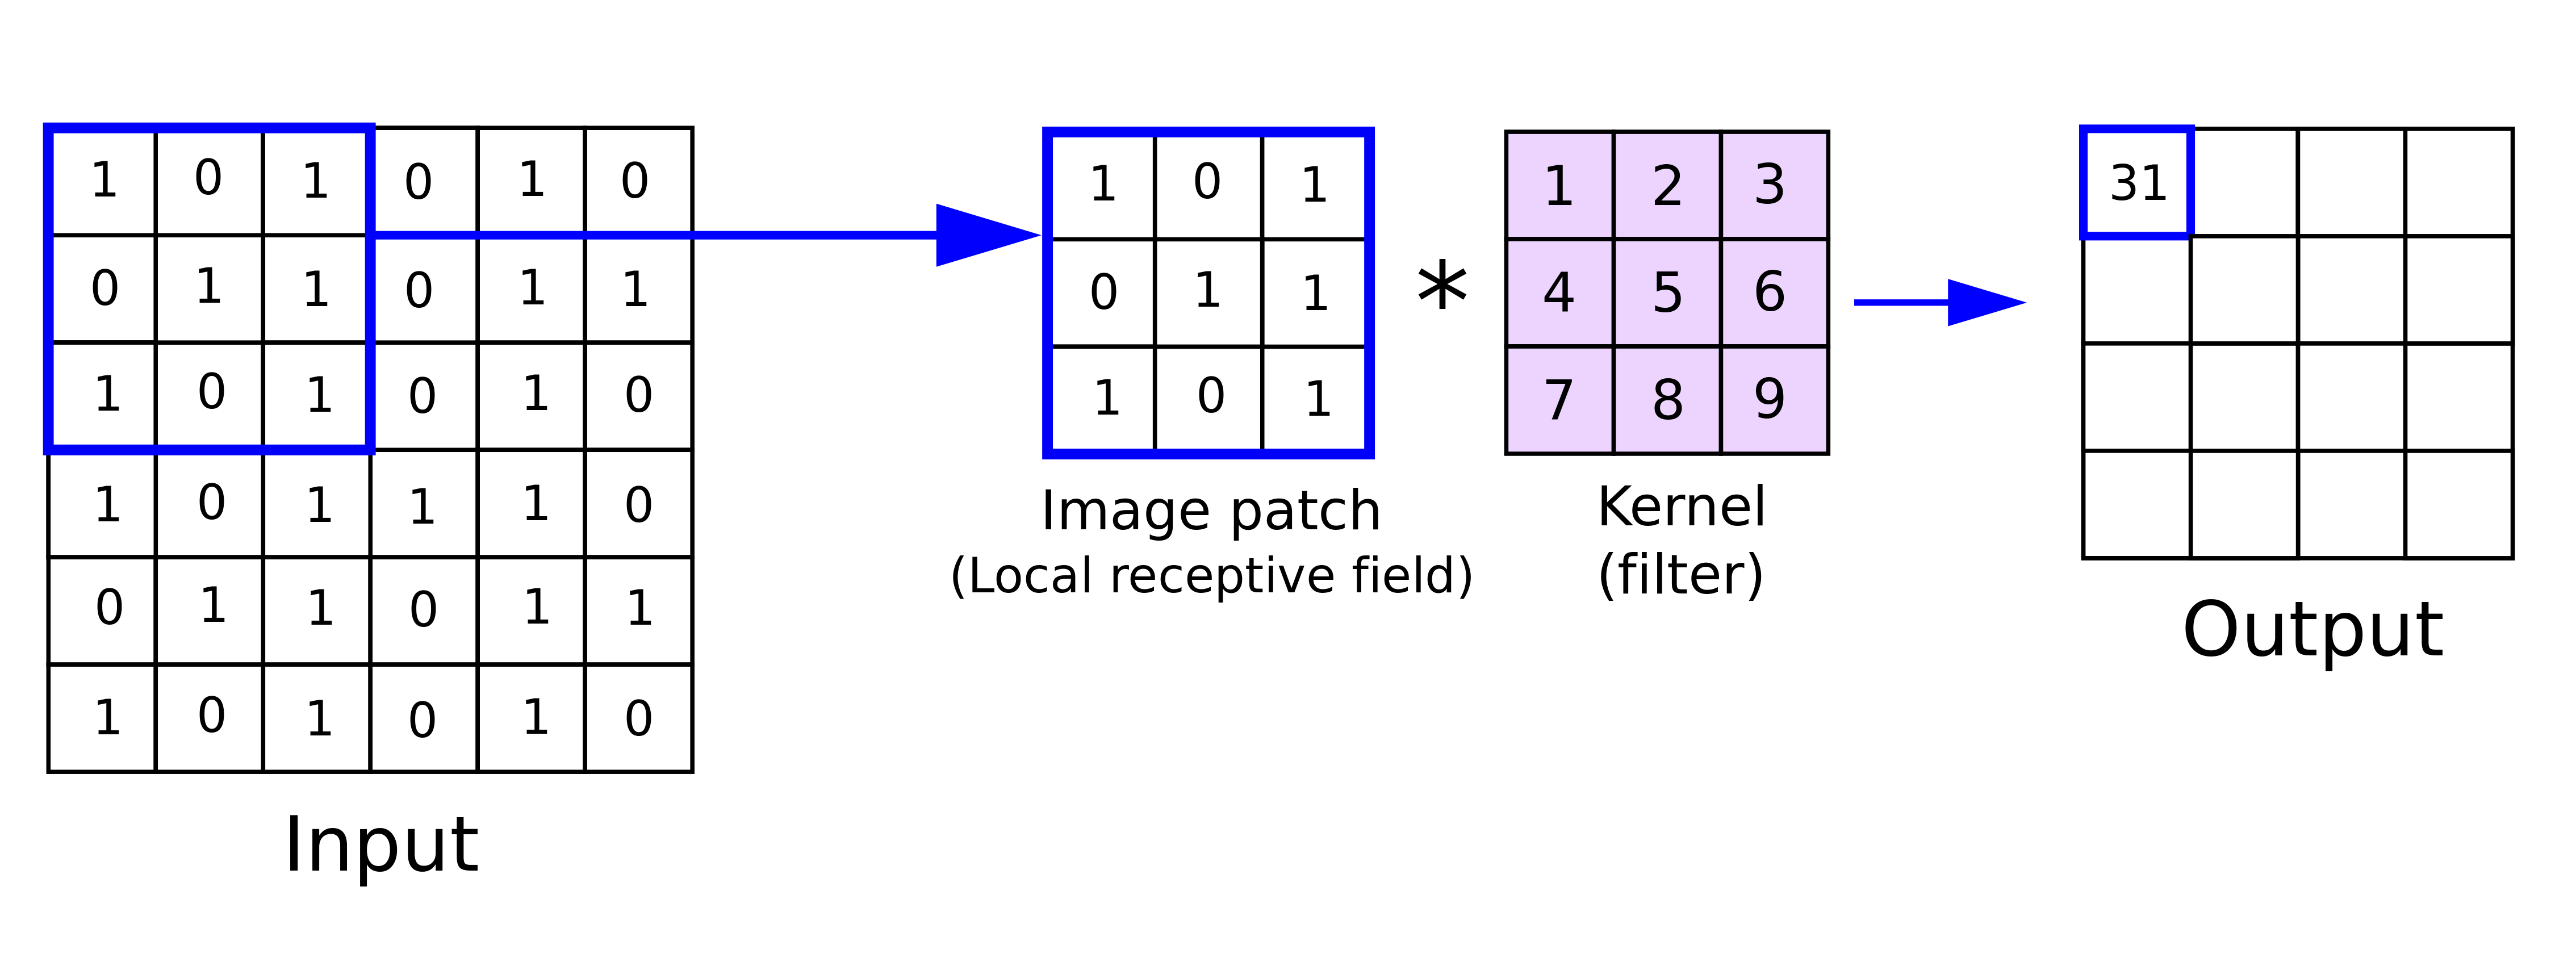
MaxPooling Layer: Là layer thường được chèn giữa các layer tích chập đóng vai trò tối ưu, truyền lại cho layer sau những giá trị tốt nhất và làm giảm kích thước đầu vào qua đó giảm được lượng lớn tham số của mô hình, giúp tăng tốc độ tính toán mà vẫn giữ được hiệu quả.

Các lớp Fully Connected cuối cùng nhằm mục đích tổng hợp những tinh túy được trích xuất từ các layer trước và đưa ra kết quả dự đoán.

khi so sánh giữa mô hình có nhiều kernel ở các layer đầu với mô hình có nhiều kernel ở các layer cuối, kết quả cho thấy mô hình có nhiều kernel ở các layer đầu có kết quả cải thiện hơn mô hình còn lại khoảng 3-4%. Kết quả ta có mô hình với khoảng hơn 1 triệu parameters cần huấn luyện, phù hợp với bài toán và điều kiện phần cứng.

Phần dữ liệu hình ảnh gốc có kích thước 73x100 pixel được resize thành 150x150 pixel tương đối nhỏ và phần nào biến dạng. Do đó, kích thước filter (kernel) tiêu chuẩn 3x3 với no padding là lựa chọn tốt để không bị mất quá nhiều dữ liệu, đặc biệt là với ảnh đã được cắt sát mặt, khả năng cao mọi pixel đều có thông tin quan trọng.

L2 Regularzation được thêm vào với mức can thiệp vào Loss Function là nhỏ 0.001 để đề phòng hiện tượng Overfitting.

In [22]:
model = keras.models.load_model("/content/drive/MyDrive/model.h5")

In [ ]:
model=models.Sequential()

model.add(layers.Conv2D(kernel_n[0],
                        kernel_s,
                        activation='relu',
                        input_shape=(150,150,3),
                        kernel_regularizer=reg_type,
                        padding="valid")
)
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(kernel_n[1],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(kernel_n[2],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(kernel_n[3],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(kernel_n[4],kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       147712    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 256)      0

In [14]:
opt_type=keras.optimizers.RMSprop(learning_rate=0.0005)
steps=60
epoch_n=30

Bước chọn phương pháp tối ưu và learning rate và vô cùng quan trọng, chiếm phần lớn thời gian trong việc xây dựng mô hình. Bảng dưới đây so sánh hiệu quả mô hình ứng với các phương pháp, learning rate và epoch, step khác nhau.

Sau 30 epochs, 60 steps/epoch, mô hình đã xây dựng gần như đã đạt hiệu quả cao nhất có thể khi việc train thêm 10 epochs không giúp mô hình cải thiện thêm được gì.
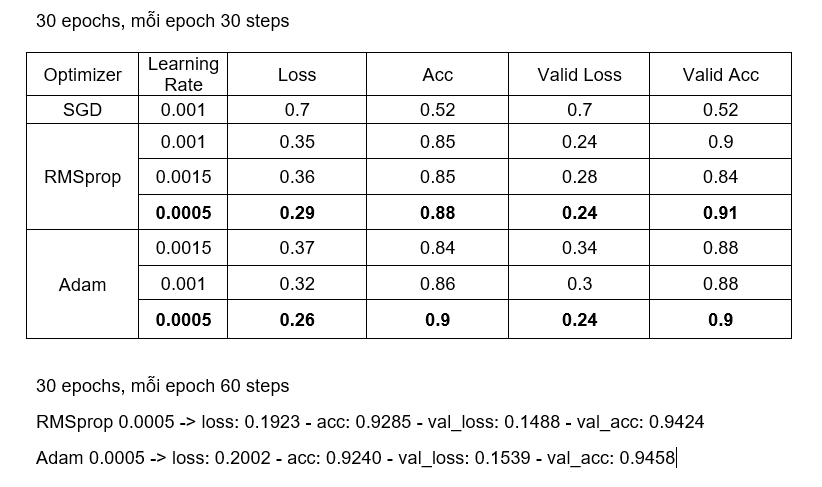

In [15]:
model.compile(optimizer=opt_type,loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history=model.fit(train_gen,
                  steps_per_epoch=steps,
                  epochs=epoch_n,
                  validation_data=valid_gen,
                  validation_steps=steps)

Epoch 1/30
60/60 [==============================] - 28s 301ms/step - loss: 0.7104 - acc: 0.5040 - val_loss: 0.6881 - val_acc: 0.6038
Epoch 2/30
60/60 [==============================] - 18s 304ms/step - loss: 0.6647 - acc: 0.5997 - val_loss: 0.6042 - val_acc: 0.6979
Epoch 3/30
60/60 [==============================] - 18s 300ms/step - loss: 0.5679 - acc: 0.7135 - val_loss: 0.4819 - val_acc: 0.7601
Epoch 4/30
60/60 [==============================] - 18s 300ms/step - loss: 0.4789 - acc: 0.7747 - val_loss: 0.3239 - val_acc: 0.8799
Epoch 5/30
60/60 [==============================] - 18s 301ms/step - loss: 0.3884 - acc: 0.8389 - val_loss: 0.2613 - val_acc: 0.8993
Epoch 6/30
60/60 [==============================] - 18s 297ms/step - loss: 0.3859 - acc: 0.8326 - val_loss: 0.2637 - val_acc: 0.8979
Epoch 7/30
60/60 [==============================] - 18s 299ms/step - loss: 0.3592 - acc: 0.8507 - val_loss: 0.4765 - val_acc: 0.7965
Epoch 8/30
60/60 [==============================] - 20s 338ms/step - 

In [ ]:
model.save('model.h5')

<Figure size 432x288 with 0 Axes>

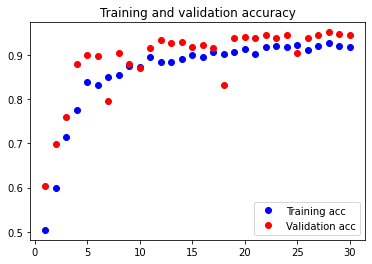

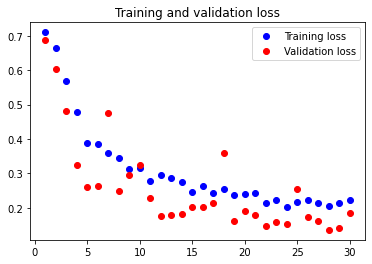

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# **Kiểm tra độ chính xác của mô hình**






In [16]:
test_datagen1 = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen1.flow_from_directory(
'/content/data/Validation',
target_size=(150,150),
batch_size=128,
class_mode='binary')

Found 11649 images belonging to 2 classes.


In [23]:
test_loss, test_acc = model.evaluate(test_generator, steps=32)
print('test acc:', test_acc)
print('test_loss:',test_loss)

32/32 [==============================] - 5s 121ms/step - loss: 0.1884 - acc: 0.9412
test acc: 0.941162109375
test_loss: 0.18843503296375275


In [24]:
batch_num=random.randrange(len(test_gen))
predict=model.predict(test_gen[batch_num][0]).reshape(-1).round()
label=test_gen[batch_num][1]
diff_arr=abs(predict - label)
diff_num=int(sum(abs(predict - label)))
print('Do chinh xac du doan: ', 1-diff_num/len(diff_arr))
_, pic = plt.subplots(max(2,int(np.ceil(diff_num/5))), 5, figsize=(20,10))
row=0
col=0
for i in range(len(diff_arr)):
  if diff_arr[i] != 0:
    pic[row][col].imshow(test_gen[batch_num][0][i])
    pic[row][col].set_title('label: '+str(label[i])+ ' predict: '+str(predict[i]))
    pic[row][col].axis("off")
    col=col+1
    if col==5:
      row=row+1
      col=0
plt.show()

NameError: ignored

Bây giờ ta sẽ thử dùng các bức ảnh tùy ý để xem model dự đoán kết quả như thế nào.

In [19]:
# new data from outside kaggle website to test on it.
male_path = '/content/drive/MyDrive/test2/male/'
female_path = '/content/drive/MyDrive/test2/female/'

In [20]:
# function that display image, its gender and percentage of gender.
def show_image(im, row, col, result):
    if int(result*2) >= 1:
        percentage = (round(float(((result[0]-0.5 ) +0.5 )* 100 ),2))
        title = f"Male:{percentage}%"
    else:
        percentage = (round(float(((0.5-result[0])+0.5)* 100 ),2))
        title = f"Female:{percentage}%"
    
    ax[row][col].imshow(im)
    ax[row][col].set_title(title)
    ax[row][col].axis("off")

1/1 [==============================] - 0s 26ms/step


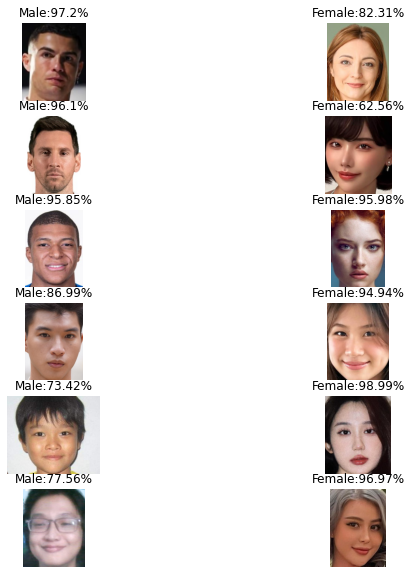

In [25]:
from skimage.transform import resize
# create subplot for outside image.
fig, ax = plt.subplots(6,2,figsize=(10,10))

# loop on new image predict and display.
for row in range(6):
    im_0 = plt.imread(male_path + str(row+1) + '.jpg')
    im_1 = plt.imread(female_path + str(row+1) + '.jpg')
    
    im_0_resize = resize(im_0, (150,150))
    im_1_resize = resize(im_1, (150,150))
    
    im_0_resize = np.expand_dims(im_0_resize, axis =0)
    im_1_resize = np.expand_dims(im_1_resize, axis =0)
    
    result_0 = model.predict(im_0_resize)
    result_1 = model.predict(im_1_resize)
    
    show_image(im_0, row, 0, result_0)
    show_image(im_1, row, 1, result_1)
    
plt.show()

**Nhận xét: ** Do là trong dataset của ta đa số là các hình ảnh khuôn mặt đầy đủ, không có vật gì che khuất. Vì vậy, các hình [2][2], [5][1] và [6][1] ở đây có các vật cản như là tóc mái hoặc mắt kính, do đó độ chính xác không được cao.